# Actuator data analysis

In [18]:
import numpy as np
import pandas as pd
import random
import pickle 

import sklearn
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.pyplot import figure
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap

In [19]:
# read google spreadsheet data saved as csv
df = pd.read_csv("original_data.csv")
# delete first column from dataframe
df = df.drop('Reference', axis=1)

In [20]:
print(df['Actuator Type'].unique())
# remove SMP actuator type
df = df[df['Actuator Type'] != 'SMP']
df = df[df['Actuator Type'] != 'TSA']
print(df['Actuator Type'].unique())
# define actuator class names
classes = df['Actuator Type'].unique()
two_clas = ["SMA", "SCP"]
cls2num = {c:i for i, c in enumerate(classes)}
print(cls2num)
# for getting the class name from int representation
num2cls = {i:c for i, c in enumerate(classes)}
print(num2cls)

labels = df['Actuator Type'].apply(lambda t: cls2num[t])
df['Label'] = labels
print(df['Label'].unique())

['PZT' 'DEA' 'IPMC' 'SMA' 'SFA' 'TSA' 'SCP' 'EAP' 'SMP']
['PZT' 'DEA' 'IPMC' 'SMA' 'SFA' 'SCP' 'EAP']
{'PZT': 0, 'DEA': 1, 'IPMC': 2, 'SMA': 3, 'SFA': 4, 'SCP': 5, 'EAP': 6}
{0: 'PZT', 1: 'DEA', 2: 'IPMC', 3: 'SMA', 4: 'SFA', 5: 'SCP', 6: 'EAP'}
[0 1 2 3 4 5 6]


In [21]:
feature_names = df.columns[1:-1]
print(feature_names)

Index(['Bandwidth (Hz)', 'Strain (%)', 'Stress (MPa)', 'Efficiency (%)',
       'Power Density (W/g)'],
      dtype='object')


In [22]:
# top-n accuracies function
def top_n_acc(preds, truths, n):
    if n is None and preds.ndim == 1:
        return np.sum(preds==truths, dtype=float)/len(preds)
    else:
        best_n = np.argsort(preds, axis=1)[:, -n:]
        if isinstance(truths, np.ndarray):
            truths = truths.reshape(-1, 1)
        # if isinstance(truths, np.ndarray) and n==1:
        #     print('\n')
        #     # , best_n)
        #     print(np.sum(best_n==truths, dtype=float))
        #     print((best_n==truths).shape)
        #     # print(truths)
        #     np.sum(best_n==truths, dtype=float)/len(preds)
        return np.sum(best_n==truths, dtype=float)/len(preds)

In [23]:
def cv_acc(clf, X, y, method, n_splits=5, n_top=3,verbose=False):
    if verbose:
        print(clf.__dict__)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    scores = cross_val_predict(clf, X, y, cv=kf, method=method)
    top1 = []
    topn = []
    for cat in range(len(classes)):
        if scores.ndim == 2:
            top1.append(top_n_acc(scores[y==cat], cat, 1))
            topn.append(top_n_acc(scores[y==cat], cat, n_top))
        else:
            top1.append(top_n_acc(scores[y==cat], cat, None))
            topn.append(None)
        if verbose:
            print(f1, f2, num2cls[cat], 'top1 acc', top1[-1])
            print(f1, f2, num2cls[cat], 'top{} acc'.format(n_top), topn[-1])
    if scores.ndim == 2:
        top1_total = top_n_acc(scores, y, 1)
        topn_total = top_n_acc(scores, y, n_top)
    else:
        top1_total = top_n_acc(scores, y, None)
        topn_total = None
    if verbose:
        print(f1, f2, 'total', 'top1 acc', top1_total)
        print(f1, f2, 'total', 'top{} acc'.format(n_top), topn_total)
    return top1, top1_total, topn, topn_total

In [24]:
def collect_results(res_dict, num2cls, f1, f2, method, C, break_ties, probability, n_top, top1_class, top1_total, topn_class, topn_total):
    res_dict['f1'].append(f1)
    res_dict['f2'].append(f2)
    res_dict['method'].append(method)
    res_dict['C'].append(C)
    res_dict['break_ties'].append(break_ties)
    res_dict['probability'].append(probability)
    for cat in range(len(top1_class)):
        res_dict['{}_top{}'.format(num2cls[cat], 1)].append(top1_class[cat])
    res_dict['total_top1'].append(top1_total)
    for cat in range(len(topn_class)):
        res_dict['{}_top{}'.format(num2cls[cat], n_top)].append(topn_class[cat])
    res_dict['total_top{}'.format(n_top)].append(topn_total)

In [25]:
n_top = 3
n_splits = 5
keys = ['f1', 'f2', 'method', 'C', 'break_ties', 'probability']
for k in [1, n_top]:
    for cat in classes.tolist() + ['total']:
        keys.append('{}_top{}'.format(cat, k))
results = {k: [] for k in keys}
print(results)
# cfgs = { # For comparing different C's when using predict: should choose different C for each classifier based on macro avg of recall
#     'C': [1000, 1000, 100, 100, 10, 10, 1, 1],
#     'probability': [False, False, False, False, False, False, False, False, ],
#     'break_ties': [False, True, False, True, False, True, False, True, ],
#     'method': ['predict', 'predict', 'predict', 'predict', 'predict', 'predict', 'predict', 'predict', ]
# }
# cfgs = { # Confirming decision_function top1 == predict with break_ties=True
#     'C': [1000, 1000, 100, 100, 10, 10, 1, 1],
#     'probability': [False, False, False, False, False, False, False, False, ],
#     'break_ties': [True, True, True, True, True, True, True, True, ],
#     'method': ['predict', 'decision_function', 'predict', 'decision_function', 'predict', 'decision_function', 'predict', 'decision_function', ]
# }
# cfgs = { # Confirming probability=True/False does not influence decision_function
#     'C': [1000, 1000, 100, 100, 10, 10, 1, 1],
#     'probability': [False, True, False, True, False, True, False, True, ],
#     'break_ties': [True, True, True, True, True, True, True, True, ],
#     'method': ['decision_function', 'decision_function', 'decision_function', 'decision_function', 'decision_function', 'decision_function', 'decision_function', 'decision_function', ]
# }
cfgs = {
    'C': [1000, 1000, 100, 100, 10, 10, 1, 1],
    'probability': [True, True, True, True, True, True, True, True, ],
    'break_ties': [True, True, True, True, True, True, True, True, ],
    'method': ['decision_function', 'predict_proba', 'decision_function', 'predict_proba', 'decision_function', 'predict_proba', 'decision_function', 'predict_proba', ]
}

for i in range(len(feature_names)): 
    for j in range(i+1, len(feature_names)): 
        f1 = feature_names[i]
        f2 = feature_names[j]
        df_temp = df[[f1, f2, 'Label']].dropna()
        # drop first column now that we have labels 
        X = df_temp[[f1, f2]].apply(pd.to_numeric).apply(np.log).to_numpy() #logged here
        if any(np.isnan(X.reshape(-1)) + np.isinf(X.reshape(-1))):
            print(df_temp[np.any(np.isnan(X)+np.isinf(X), axis=1)])
        y = df_temp['Label'].to_numpy()
        
        scaler = StandardScaler()
        # scales data by removing mean and scaling to the variance
        scaler.fit(X)
        
        # applies scaler to dataset 
        X = scaler.transform(X)
        
        # set up classifier
        # clf = OneVsRestClassifier(SVC(kernel = 'rbf', C=1000, probability=True)).fit(x_train, y_train) #ovr classifier
        
        for C, use_prob, break_ties, method in zip(cfgs['C'], cfgs['probability'], cfgs['break_ties'], cfgs['method']):
            clf = SVC(kernel = 'rbf', C=C, probability=use_prob, break_ties=break_ties, random_state=0)
            top1, top1_total, topn, topn_total = cv_acc(clf, X, y, method, n_splits=n_splits, n_top=n_top)
            collect_results(results, num2cls, f1, f2, method, C, break_ties, use_prob, n_top, top1, top1_total, topn, topn_total)
        
res_df = pd.DataFrame(results)
#res_df.to_csv('results.csv')



{'f1': [], 'f2': [], 'method': [], 'C': [], 'break_ties': [], 'probability': [], 'PZT_top1': [], 'DEA_top1': [], 'IPMC_top1': [], 'SMA_top1': [], 'SFA_top1': [], 'SCP_top1': [], 'EAP_top1': [], 'total_top1': [], 'PZT_top3': [], 'DEA_top3': [], 'IPMC_top3': [], 'SMA_top3': [], 'SFA_top3': [], 'SCP_top3': [], 'EAP_top3': [], 'total_top3': []}


/Users/angelaliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/angelaliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/angelaliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/angelaliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/angelaliu/opt/anaconda3/lib/pytho

/Users/angelaliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/angelaliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:905: RuntimeWarning: Number of classes in training fold (6) does not match total number of classes (7). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  RuntimeWarning)
/Users/angelaliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/angelaliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:905: RuntimeWarning: Number of classes in training fold (6) does no

/Users/angelaliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/angelaliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/angelaliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/angelaliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/angelaliu/opt/anaconda3/lib/pytho

From the results we gathered, we decided on using `C=10`, `decision_function`, as the overall prediction function because they yield best macro average accuracy(recall) across different classes of actuators. The following script make plots for classifiers trained on the **WHOLE** dataset using this parameter/function.

In [26]:
def get_ticktext(ticks):
    return ['{}'.format(int(t) if t >= 1 else t) if np.abs(np.log10(t)) <= 3 else '{:d}e{:d}'.format(int(t/10**np.log10(t)), int(np.log10(t))) for t in ticks]

[0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
<class 'numpy.ndarray'>
(6,)
0 5 Index(['Bandwidth (Hz)', 'Strain (%)', 'Stress (MPa)', 'Efficiency (%)',
       'Power Density (W/g)'],
      dtype='object')
[[-0.21870142 -0.26803789]]
0 5 Index(['Bandwidth (Hz)', 'Strain (%)', 'Stress (MPa)', 'Efficiency (%)',
       'Power Density (W/g)'],
      dtype='object')
[[-0.28844576  0.06859433]]
0 5 Index(['Bandwidth (Hz)', 'Strain (%)', 'Stress (MPa)', 'Efficiency (%)',
       'Power Density (W/g)'],
      dtype='object')
[[-0.7876644  -0.20989275]]
0 5 Index(['Bandwidth (Hz)', 'Strain (%)', 'Stress (MPa)', 'Efficiency (%)',
       'Power Density (W/g)'],
      dtype='object')
[[-0.45945335  0.96490453]]
1 5 Index(['Bandwidth (Hz)', 'Strain (%)', 'Stress (MPa)', 'Efficiency (%)',
       'Power Density (W/g)'],
      dtype='object')
[[ 0.42869002 -0.63529503]]
1 5 Index(['Bandwidth (Hz)', 'Strain (%)', 'Stress (MPa)', 'Efficiency (%)',
       'Power Density (W/g)'],
      dtype='object')
[[ 0.12733423

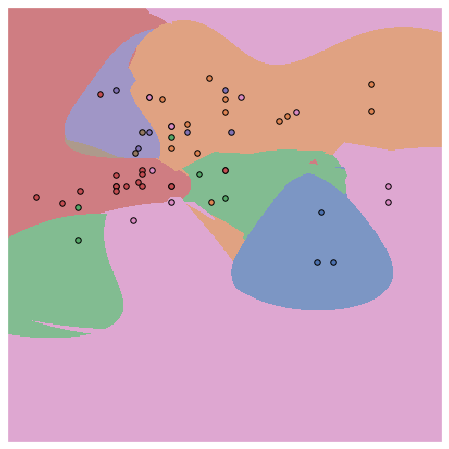

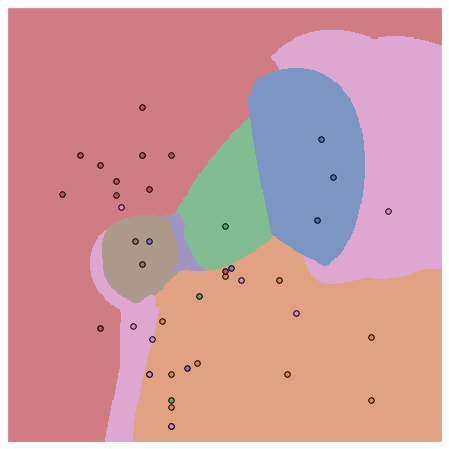

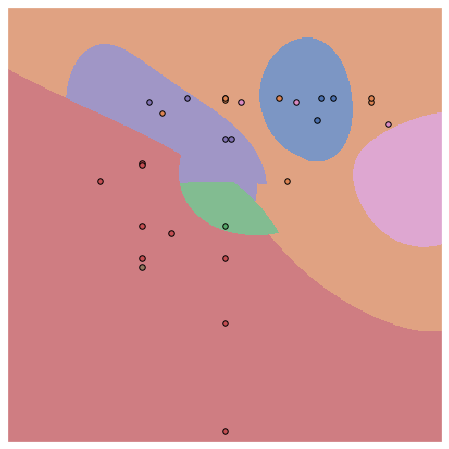

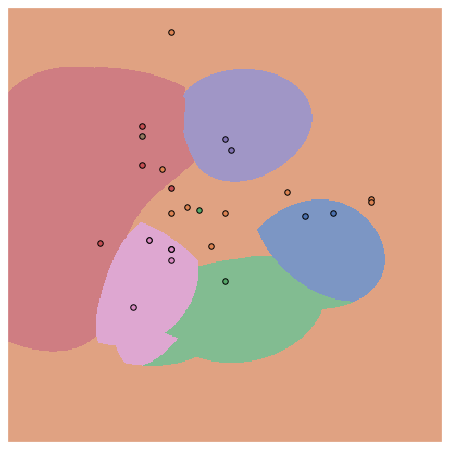

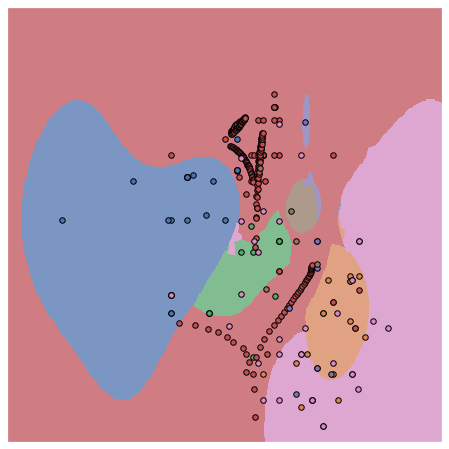

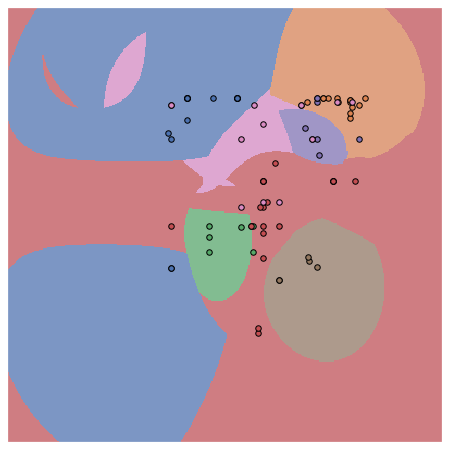

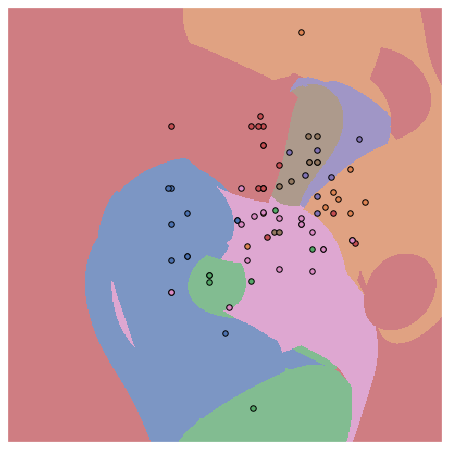

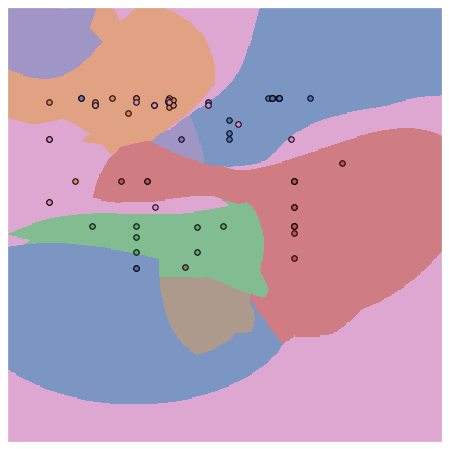

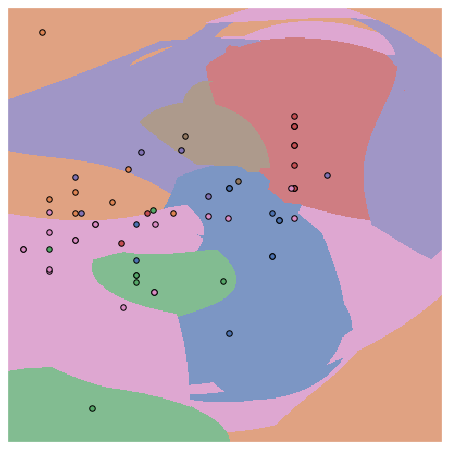

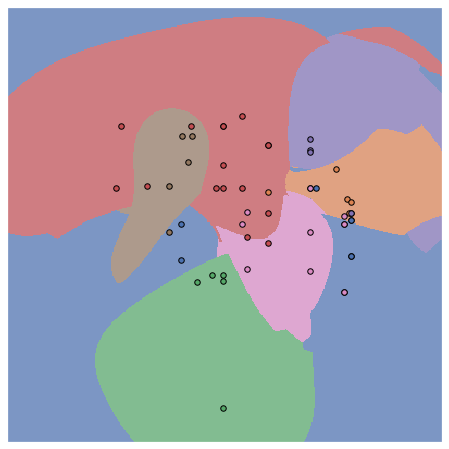

In [41]:
C = 10
use_prob = False
break_ties = True

# create df to hold preset tick marks 
ticklabels = {}
ticklabels['Bandwidth (Hz)'] = np.power(10., [-2, 0, 2, 4, 6])
ticklabels['Strain (%)'] = np.power(10., [-4, -2, 0, 2, 4]) #[0.001, 0.1, 10, 1000, 1e5]
ticklabels['Stress (MPa)'] = np.power(10., [-1, 0, 1, 2, 3, 4]) # [0.1, 1, 10, 100, 1000, 10000]
ticklabels['Efficiency (%)'] = np.power(10., [-2, -1, 0, 1, 2, 3]) # [0.01, 0.1, 1, 10, 100, 1000] 
ticklabels['Power Density (W/g)'] = np.power(10., [-7, -4, -1, 2, 5]) # [1e-7, 0.0001, 0.1, 100, 1e5]
xlabels = ticklabels.get(f1)
ylabels = ticklabels.get(f2)
print(list(xlabels))
print(type(xlabels))
print(xlabels.shape)

sns.set_theme()
size = [400, 400]
my_cmap = ListedColormap(sns.color_palette(n_colors=7))
# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

for i in range(len(feature_names)): 
    for j in range(i+1, len(feature_names)):
        print(i, len(feature_names), feature_names)
        f1 = feature_names[i]
        f2 = feature_names[j]
        df_temp = df[[f1, f2, 'Label']].dropna()
        # drop first column now that we have labels 
        X = df_temp[[f1, f2]].apply(pd.to_numeric).apply(np.log).to_numpy() #logged here
        # if any(np.isnan(X.reshape(-1)) + np.isinf(X.reshape(-1))):
        #     print(df_temp[np.any(np.isnan(X)+np.isinf(X), axis=1)])
        y = df_temp['Label'].to_numpy()
        
        scaler = StandardScaler()
        # scales data by removing mean and scaling to the variance
        scaler.fit(X)
        
        # applies scaler to dataset 
        X = scaler.transform(X)
        
        stdscaler = f1 + f2 + 'scaler' + '.pkl'
        stdscaler = stdscaler.replace('(Hz)', '')
        stdscaler = stdscaler.replace('(MPa)', '')
        stdscaler = stdscaler.replace('(W/g)', '')
        stdscaler = stdscaler.replace('(%)', '')
        stdscaler = stdscaler.replace('Power Density', 'PowerDensity')
        stdscaler = stdscaler.replace(' ', '_')
        pickle.dump(scaler, open(stdscaler, 'wb'))
        
        # set up classifier
        # clf = OneVsRestClassifier(SVC(kernel = 'rbf', C=1000, probability=True)).fit(x_train, y_train) #ovr classifier
        clf = SVC(kernel = 'rbf', C=C, probability=use_prob, break_ties=break_ties, random_state=0)
        clf.fit(X, y)
        
        filename = f1 + f2 + '.pkl'
        filename = filename.replace('(Hz)', '')
        filename = filename.replace('(MPa)', '')
        filename = filename.replace('Power Density', 'PowerDensity')
        filename = filename.replace('(W/g)', '')
        filename = filename.replace('(%)', '')
        filename = filename.replace(' ', '_')
        pickle.dump(clf, open(filename, 'wb'))
        
        xticklabels = ticklabels[f1]
        yticklabels = ticklabels[f2]
        xticklabeltexts, yticklabeltexts = [get_ticktext(ticklabel) for ticklabel in [xticklabels, yticklabels]]
        #print(xticklabeltexts, yticklabeltexts)
        xticks = scaler.transform(np.stack([np.log(xticklabels), np.ones_like(xticklabels)], axis=1))[:, 0]
        yticks = scaler.transform(np.stack([np.ones_like(yticklabels), np.log(yticklabels)], axis=1))[:, 1]
        xmin, xmax = xticks[[0, -1]]
        ymin, ymax = yticks[[0, -1]]
        
        xx, yy = np.meshgrid(np.linspace(xmin, xmax, size[0]), np.linspace(ymin, ymax, size[1]))
        fig, ax = plt.subplots(figsize=(4, 4))
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.imshow(Z, cmap=my_cmap, origin='lower', alpha=0.7) 
        # colorbar
        # mappable = cm.ScalarMappable(cmap=my_cmap)
        # mappable.set_array([])
        # mappable.set_clim(-0.5, len(classes)-1 +0.5) # centering
        # cb = plt.colorbar(mappable)
        # cb.set_ticks(np.linspace(0, len(classes)-1, len(classes)))
        # cb.set_ticklabels(classes)

        # ax.axis('tight')
        # ax.grid(None)

        # Plot also the training points
        for c in range(len(classes)):
            idx = np.where(y == c)
            ax.scatter(
                (X[idx, 0]-xmin)/(xmax-xmin) * Z.shape[0],  # Yuheng: shifting data range to match that of the 'image' Z
                (X[idx, 1]-ymin)/(ymax-ymin) * Z.shape[1], 
                color=my_cmap(c), label=classes[c],        # Notice the way of setting color
                edgecolor='black', s=30, vmin=0, vmax=7) 
        #ax.set_xlabel(f1) #, fontsize=20)
        #ax.set_ylabel(f2) #, fontsize=20)
        # ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

        xticks = (xticks-xmin)/(xmax-xmin) * Z.shape[0]
        yticks = (yticks-ymin)/(ymax-ymin) * Z.shape[1]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabeltexts) #, fontsize=18)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabeltexts) #, fontsize=18)
        #ax.tick_params(bottom=True, top=False, left=True, right=False)
        #ax.set_aspect('equal', adjustable='box')
        # plt.show()
#         plt.savefig('figs/{}_{}.pdf'.format(
#             f1.replace(' ', '').replace('/','_').replace('(%)', ''), 
#             f2.replace(' ', '').replace('/','_').replace('(%)', '')), bbox_inches='tight')
#             #dpi=300)
        plt.grid(b=None)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        contour = f1 + f2 + '.png'
        contour = contour.replace('(Hz)', '')
        contour = contour.replace('(MPa)', '')
        contour = contour.replace('(W/g)', '')
        contour = contour.replace('(%)', '')
        contour = contour.replace('Power Density', 'PowerDensity')
        contour = contour.replace(' ', '_')
        contour = contour.replace('_.png', '.png')
        #plt.savefig(contour, bbox_inches='tight', pad_inches=0)
        
        x_transformed = scaler.transform(np.asarray([[np.log(10), np.log(10)]]))
        print(x_transformed)